# Tutorial 3: Spatial Transcriptomics human PDAC dataset
We performed generation experiment on the human pancreatic ductal adenocarcinomas (PDAC) patient A section 1. On the tissue section, we generated unmeasured spots in the gaps of the measured spots, which are three times the number of the measured spots. We got high-density generated gene expression profiles by STAGE.

Then we performed spatial patterns analysis on both raw and generated ST data. We got spatially informative genes and divided them into several gene modules by HotSpot. 

The human PDAC Spatial Transcriptomics data can be accessed through Gene Expression Omnibus (GEO) accession [GSE111672](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE111672). The manual annotation are available at [Google Drive](https://drive.google.com/drive/folders/1Gp_dtksCFSaKCG2EUkDML4_KHDNPluSv).

## Data preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import STAGE
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd
import hotspot
from matplotlib_venn import venn2, venn2_circles

In [2]:
input_dir = "Data/T3"
counts_file = os.path.join(input_dir, 'GSM3036911_PDAC-A-ST1-filtered.txt')
meta_file = os.path.join(input_dir, 'PDAC-A-ST1-meta.txt')

In [3]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
meta_df = pd.read_csv(meta_file, sep='\t', index_col=0)
print(counts.shape, meta_df.shape)

(428, 16383) (428, 4)


In [4]:
# Coordinates (coor_x, coor_y) and label (human_anno_region)
adata = sc.AnnData(counts)
coor_df = meta_df.loc[adata.obs_names, ["coor_x", "coor_y"]]
adata.obsm["coord"] = coor_df.to_numpy()
adata.obs[meta_df.columns] = meta_df.loc[adata.obs_names, meta_df.columns]

<AxesSubplot:title={'center':'Manual Annotation'}, xlabel='coord1', ylabel='coord2'>

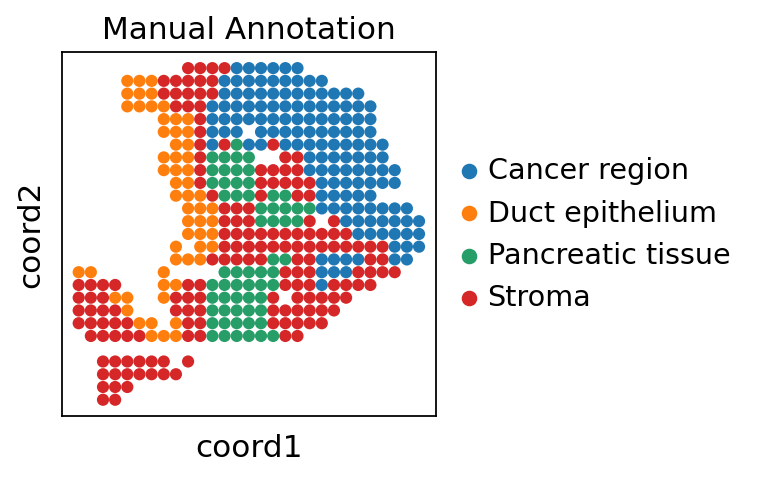

In [6]:
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.embedding(adata, basis="coord", color="human_anno_region", title='Manual Annotation', s=120, show=False)

In [7]:
sc.pp.filter_genes(adata, min_cells=10)
print('After flitering: ', adata.shape)

After flitering:  (428, 6030)


In [8]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [9]:
adata

AnnData object with n_obs × n_vars = 428 × 6030
    obs: 'coor_x', 'coor_y', 'human_anno_region', 'human_anno_cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'human_anno_region_colors', 'hvg', 'log1p'
    obsm: 'coord'

## Running model

In [10]:
adata_stage=STAGE.STAGE(
    adata, 
    save_path='./T3_PDAC', 
    data_type='ST_KTH', 
    experiment='generation', 
    coord_sf=35, 
    train_epoch=10000, 
    seed=1234, 
    batch_size=64, 
    learning_rate=1e-4, 
    w_recon=0.1, 
    w_w=0.1, 
    w_l1=0.1,
    relu=True,
    device='cuda:0'
)

Epochs: 100%|██████████| 10000/10000 [32:56<00:00,  5.06it/s, latent_loss: 0.00604, recon_loss: 0.25184, total_loss: 0.00312]


In [11]:
adata_stage

AnnData object with n_obs × n_vars = 1712 × 3000
    obsm: 'coord'

## Gene patterns analysis

This part needs [Hotpost](http://www.github.com/Yoseflab/Hotspot) package.

In [12]:
# Identifying spatially variable genes
hs = hotspot.Hotspot(adata,model='none',latent_obsm_key="coord")
hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_results = hs.compute_autocorrelations()
hs_genes = hs_results.loc[hs_results.FDR < 0.05].index

100%|██████████| 6030/6030 [00:00<00:00, 8657.32it/s] 


In [13]:
# Identifying spatially variable genes
adata_stage=adata_stage[:,pd.DataFrame(adata_stage.X).apply(lambda x: x.sum(), axis=0)>0]
hs_stage = hotspot.Hotspot(adata_stage,model='none',latent_obsm_key="coord")
hs_stage.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_stage_results = hs_stage.compute_autocorrelations()
hs_stage_genes = hs_stage_results.loc[hs_stage_results.FDR < 0.05].index

100%|██████████| 2147/2147 [00:00<00:00, 5720.51it/s]


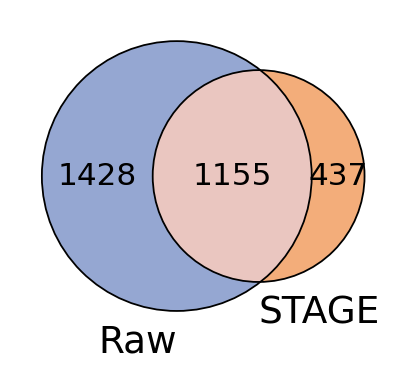

In [14]:
g=venn2(subsets = [set(hs_genes), set(hs_stage_genes)],set_labels = ('Raw', 'STAGE'),
        set_colors=("#4f6db4", "#ec7722"),alpha=0.6,normalize_to=1.0)
g=venn2_circles(subsets = [set(hs_genes), set(hs_stage_genes)], linewidth=0.8, color="black") 

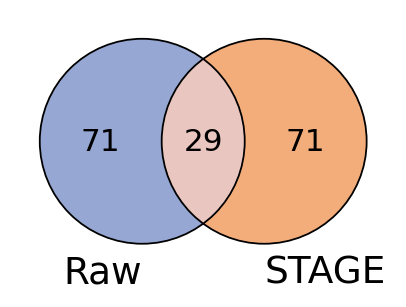

In [15]:
g=venn2(subsets = [set(hs_genes[range(100)]), set(hs_stage_genes[range(100)])],set_labels = ('Raw', 'STAGE'),
        set_colors=("#4f6db4", "#ec7722"),alpha=0.6,normalize_to=1.0)
g=venn2_circles(subsets = [set(hs_genes[range(100)]), set(hs_stage_genes[range(100)])], linewidth=0.8, color="black") 

In [16]:
hs_stage_genes[range(100)][~hs_stage_genes[range(100)].isin(hs_genes[range(100)])]

Index(['CD81', 'AC034236.1', 'MTRNR2L8', 'AC024940.2', 'AC026254.2', 'CRP',
       'AC013248.2', 'AC008481.1', 'COL3A1', 'AL356535.1', 'AC000089.1',
       'CLDN2', 'COL1A2', 'AC004386.1', 'AC125807.1', 'DUOXA2', 'AC246787.1',
       'AL138721.1', 'AC091153.1', 'AL133260.1', 'AC026436.1', 'IFI27', 'B2M',
       'AL138785.1', 'AL161787.1', 'AC010733.1', 'AL080243.2', 'FBLN1',
       'AC104212.2', 'AL590867.2', 'AC107983.1', 'AC113935.1', 'H3F3B',
       'AC024293.1', 'BX679664.3', 'AC064799.1', 'AL096701.1', 'AC099560.2',
       'AC006511.3', 'DDIT4', 'APP', 'MMP2', 'AC144530.1', 'CHCHD2',
       'AC004453.1', 'MUC6', 'AC127070.1', 'AP003385.3', 'AC010343.1',
       'AC099336.2', 'AC005912.1', 'AC018738.1', 'AP001324.1', 'AC008677.2',
       'AQP3', 'APCS', 'ACTG1', 'AL359704.1', 'FN1', 'MT2A', 'IGHA1', 'COL6A3',
       'AP000942.1', 'AP000936.3', 'HLA.DRA', 'CIRBP', 'AC005840.1',
       'FO393411.1', 'AP000354.1', 'AC092597.1', 'IGKC'],
      dtype='object', name='Gene')

In [17]:
# Select marker genes
show_gene=["DDIT4","COL1A1","MUC6"]

In [18]:
sc.set_figure_params(dpi=80, figsize=(2.8, 3))

[<AxesSubplot:title={'center':'DDIT4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'COL1A1'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'MUC6'}, xlabel='coord1', ylabel='coord2'>]

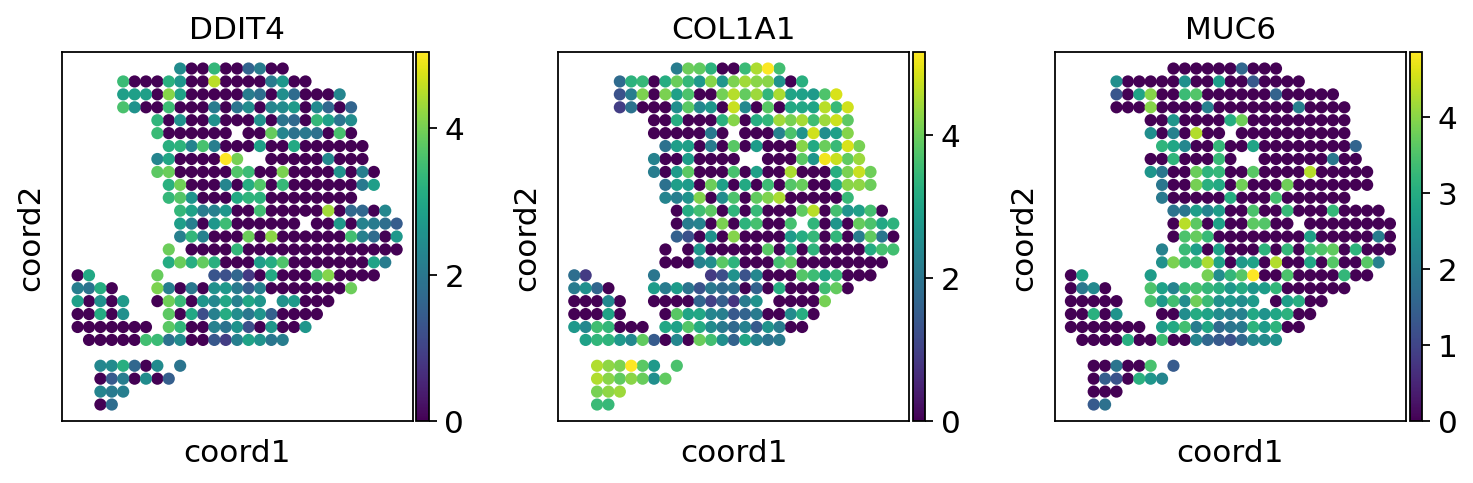

In [19]:
sc.pl.embedding(adata, basis="coord", color=show_gene, s=120, show=False)

[<AxesSubplot:title={'center':'DDIT4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'COL1A1'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'MUC6'}, xlabel='coord1', ylabel='coord2'>]

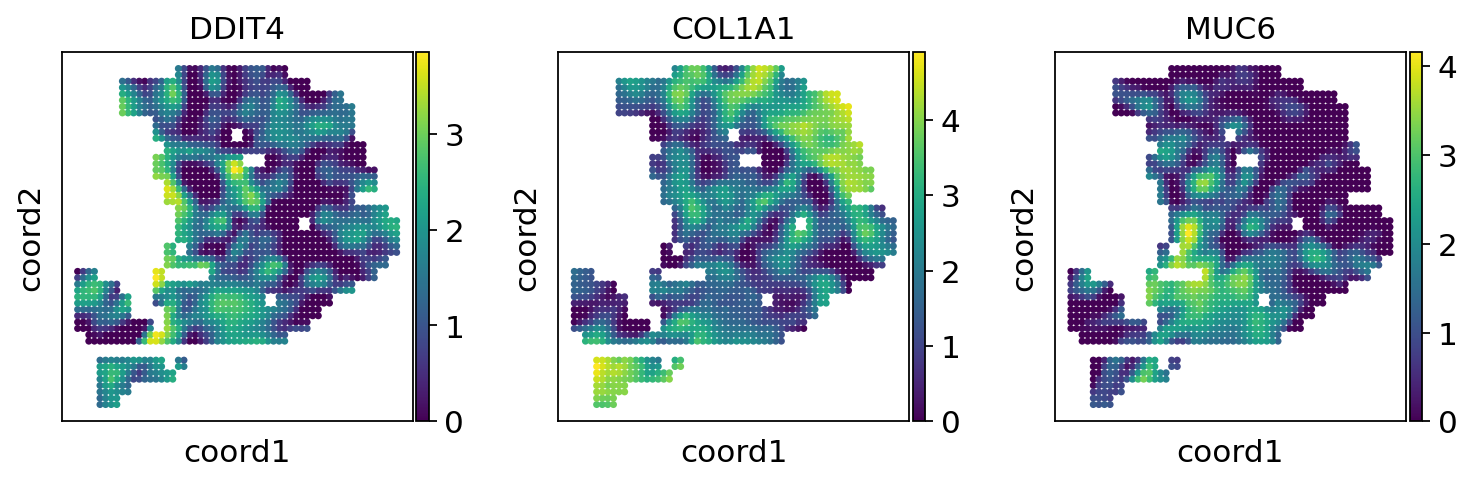

In [20]:
sc.pl.embedding(adata_stage, basis="coord", color=show_gene, s=40, show=False)

In [21]:
# Identifying gene modules
local_correlations = hs.compute_local_correlations(hs_genes, jobs=0)
modules = hs.create_modules(min_gene_threshold=20, core_only=False, fdr_threshold=0.05)
module_scores = hs.calculate_module_scores()
hs.module_scores.columns=["module "+f'{i}' for i in range(1,module_scores.shape[1]+1)]
adata.obs[hs.module_scores.columns]=hs.module_scores

Computing pair-wise local correlation on 2583 features...


100%|██████████| 3334653/3334653 [00:43<00:00, 77190.16it/s] 


Computing scores for 28 modules...


100%|██████████| 28/28 [00:01<00:00, 24.33it/s]


In [22]:
# Identifying gene modules
local_correlations_stage = hs_stage.compute_local_correlations(hs_stage_genes, jobs=0)
modules_stage = hs_stage.create_modules(min_gene_threshold=10, core_only=False, fdr_threshold=0.05)
module_scores_stage = hs_stage.calculate_module_scores()
hs_stage.module_scores.columns=["module "+f'{i}' for i in range(1,module_scores_stage.shape[1]+1)]
adata_stage.obs[hs_stage.module_scores.columns]=hs_stage.module_scores

Computing pair-wise local correlation on 1592 features...


100%|██████████| 1266436/1266436 [01:22<00:00, 15320.89it/s]


Computing scores for 33 modules...


100%|██████████| 33/33 [00:00<00:00, 35.58it/s]


[<AxesSubplot:title={'center':'module 1'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 2'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 3'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 5'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 6'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 7'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 8'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 9'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 10'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 11'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 12'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 13'}, xlabel='coord1', 

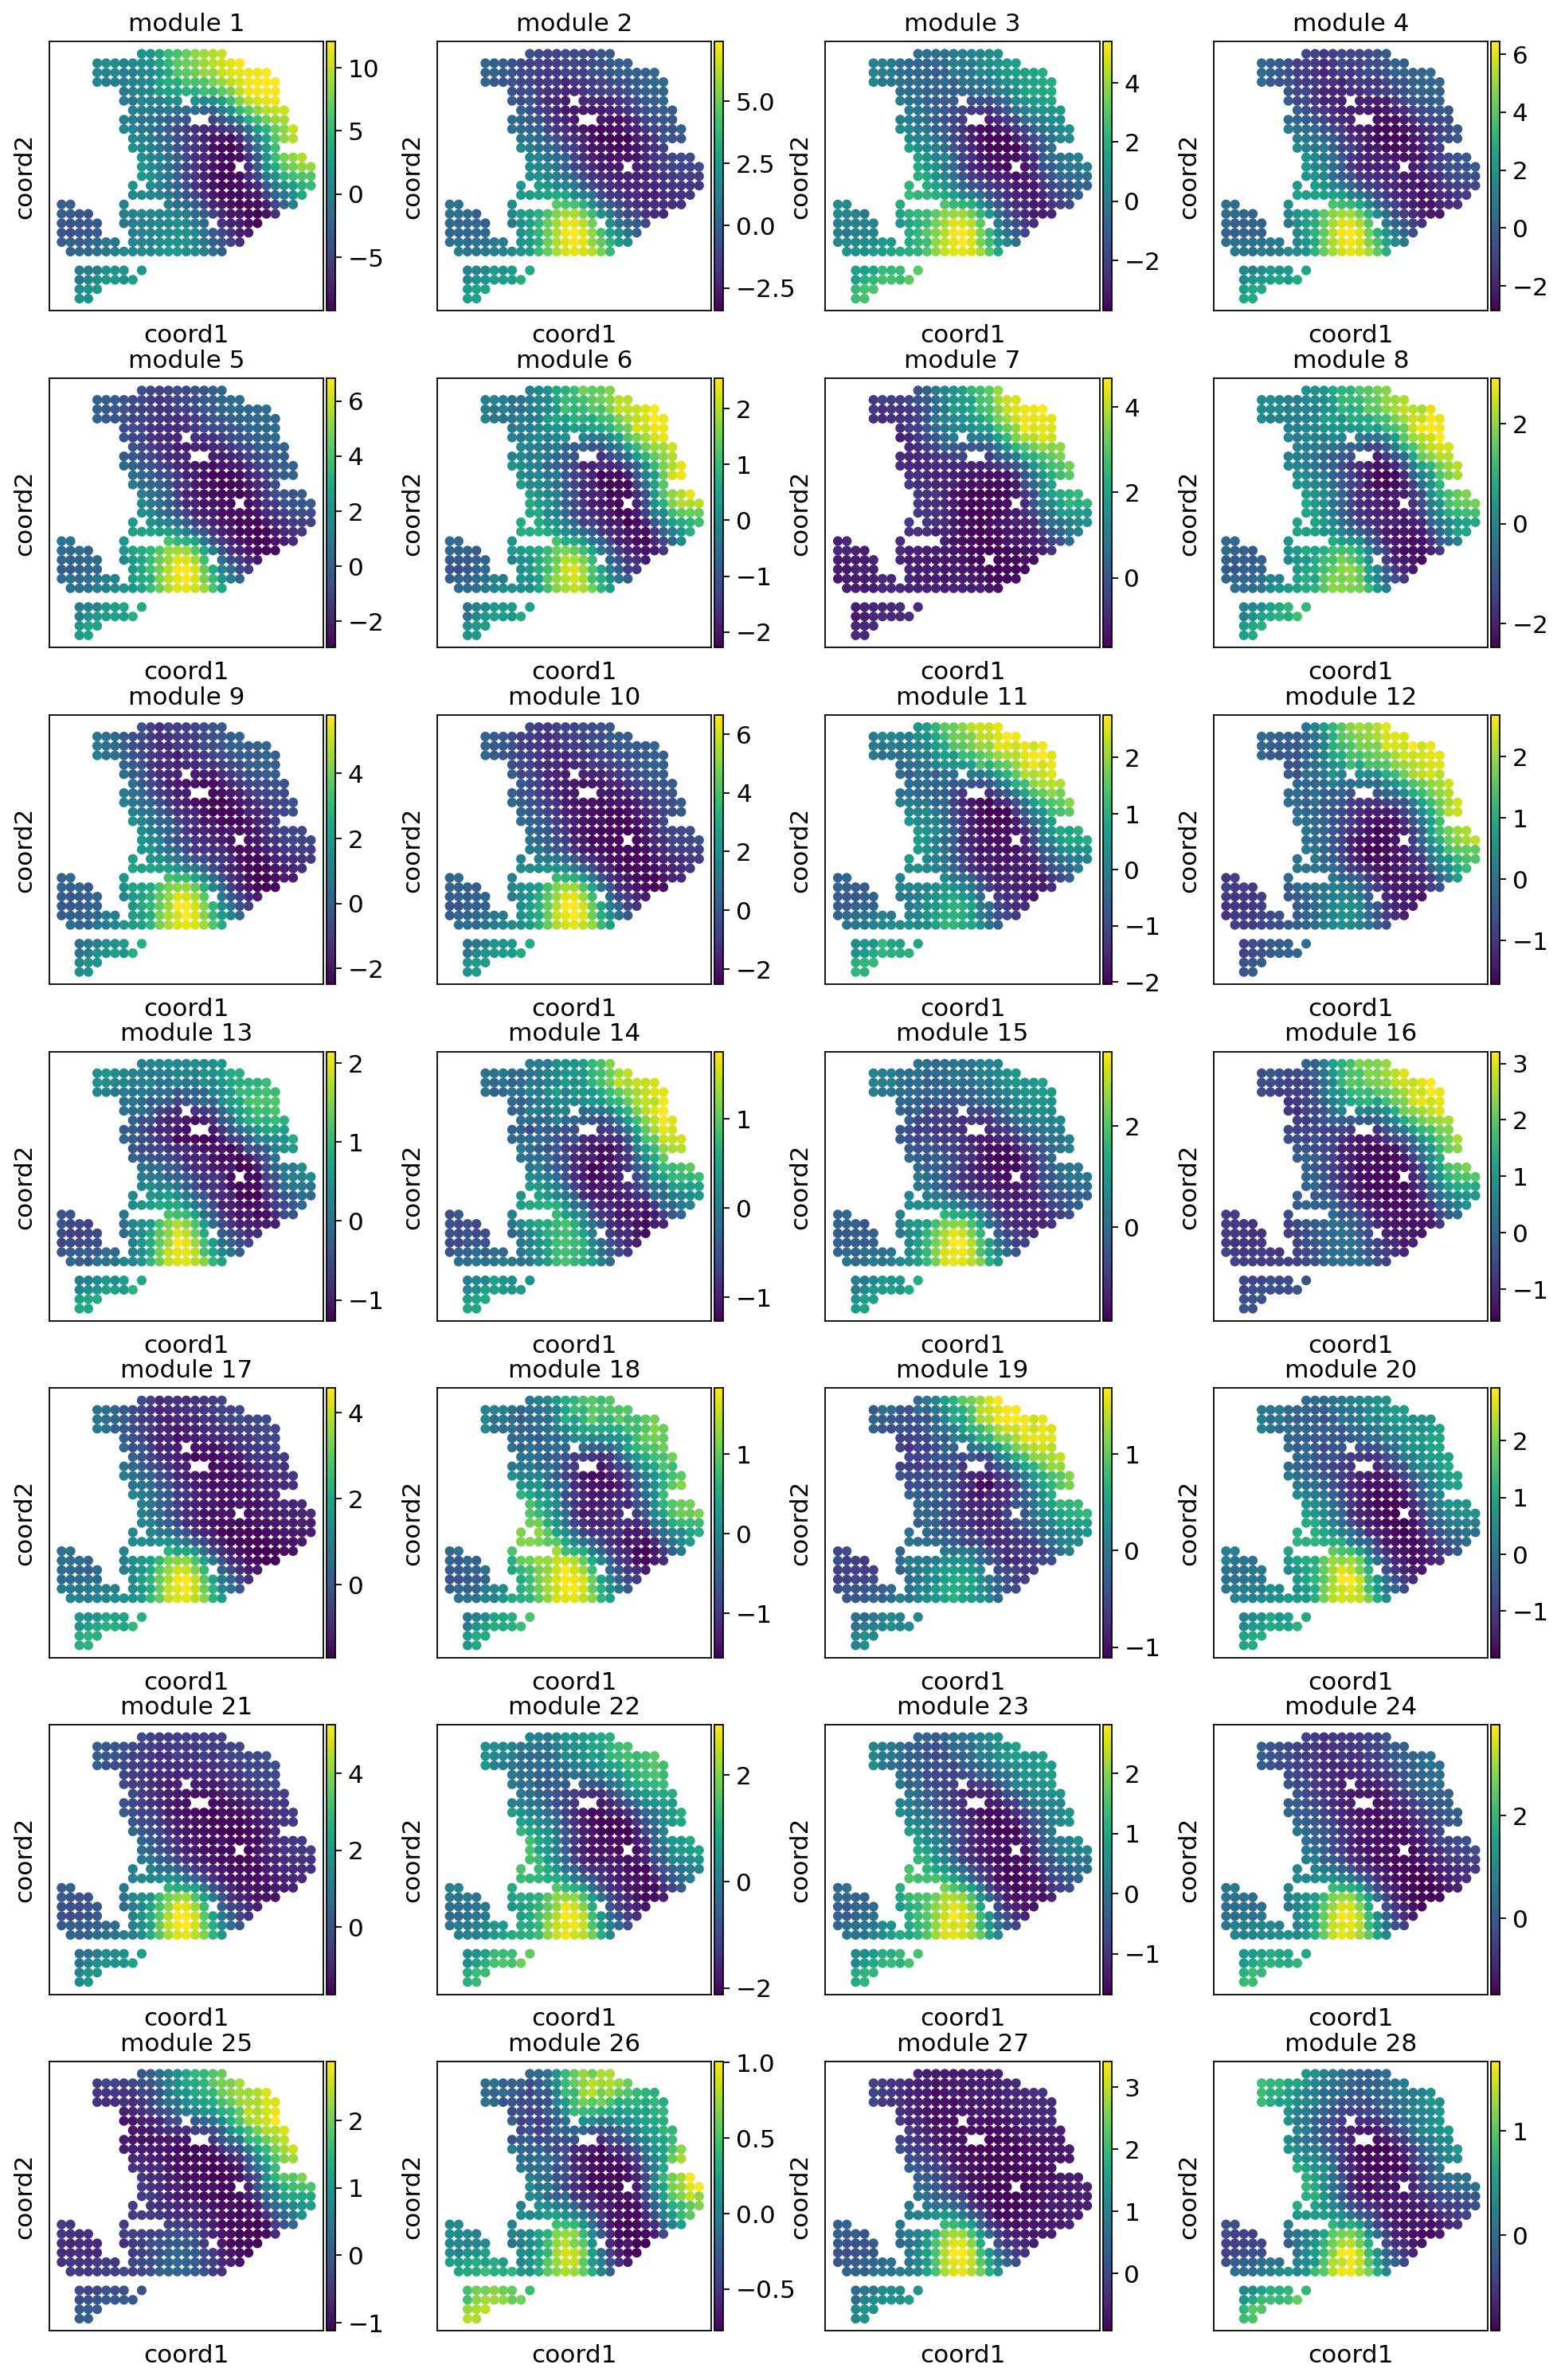

In [23]:
sc.pl.embedding(adata, basis="coord", color=hs.module_scores.columns, s=120, show=False)

[<AxesSubplot:title={'center':'module 1'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 2'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 3'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 5'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 6'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 7'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 8'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 9'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 10'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 11'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 12'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'module 13'}, xlabel='coord1', 

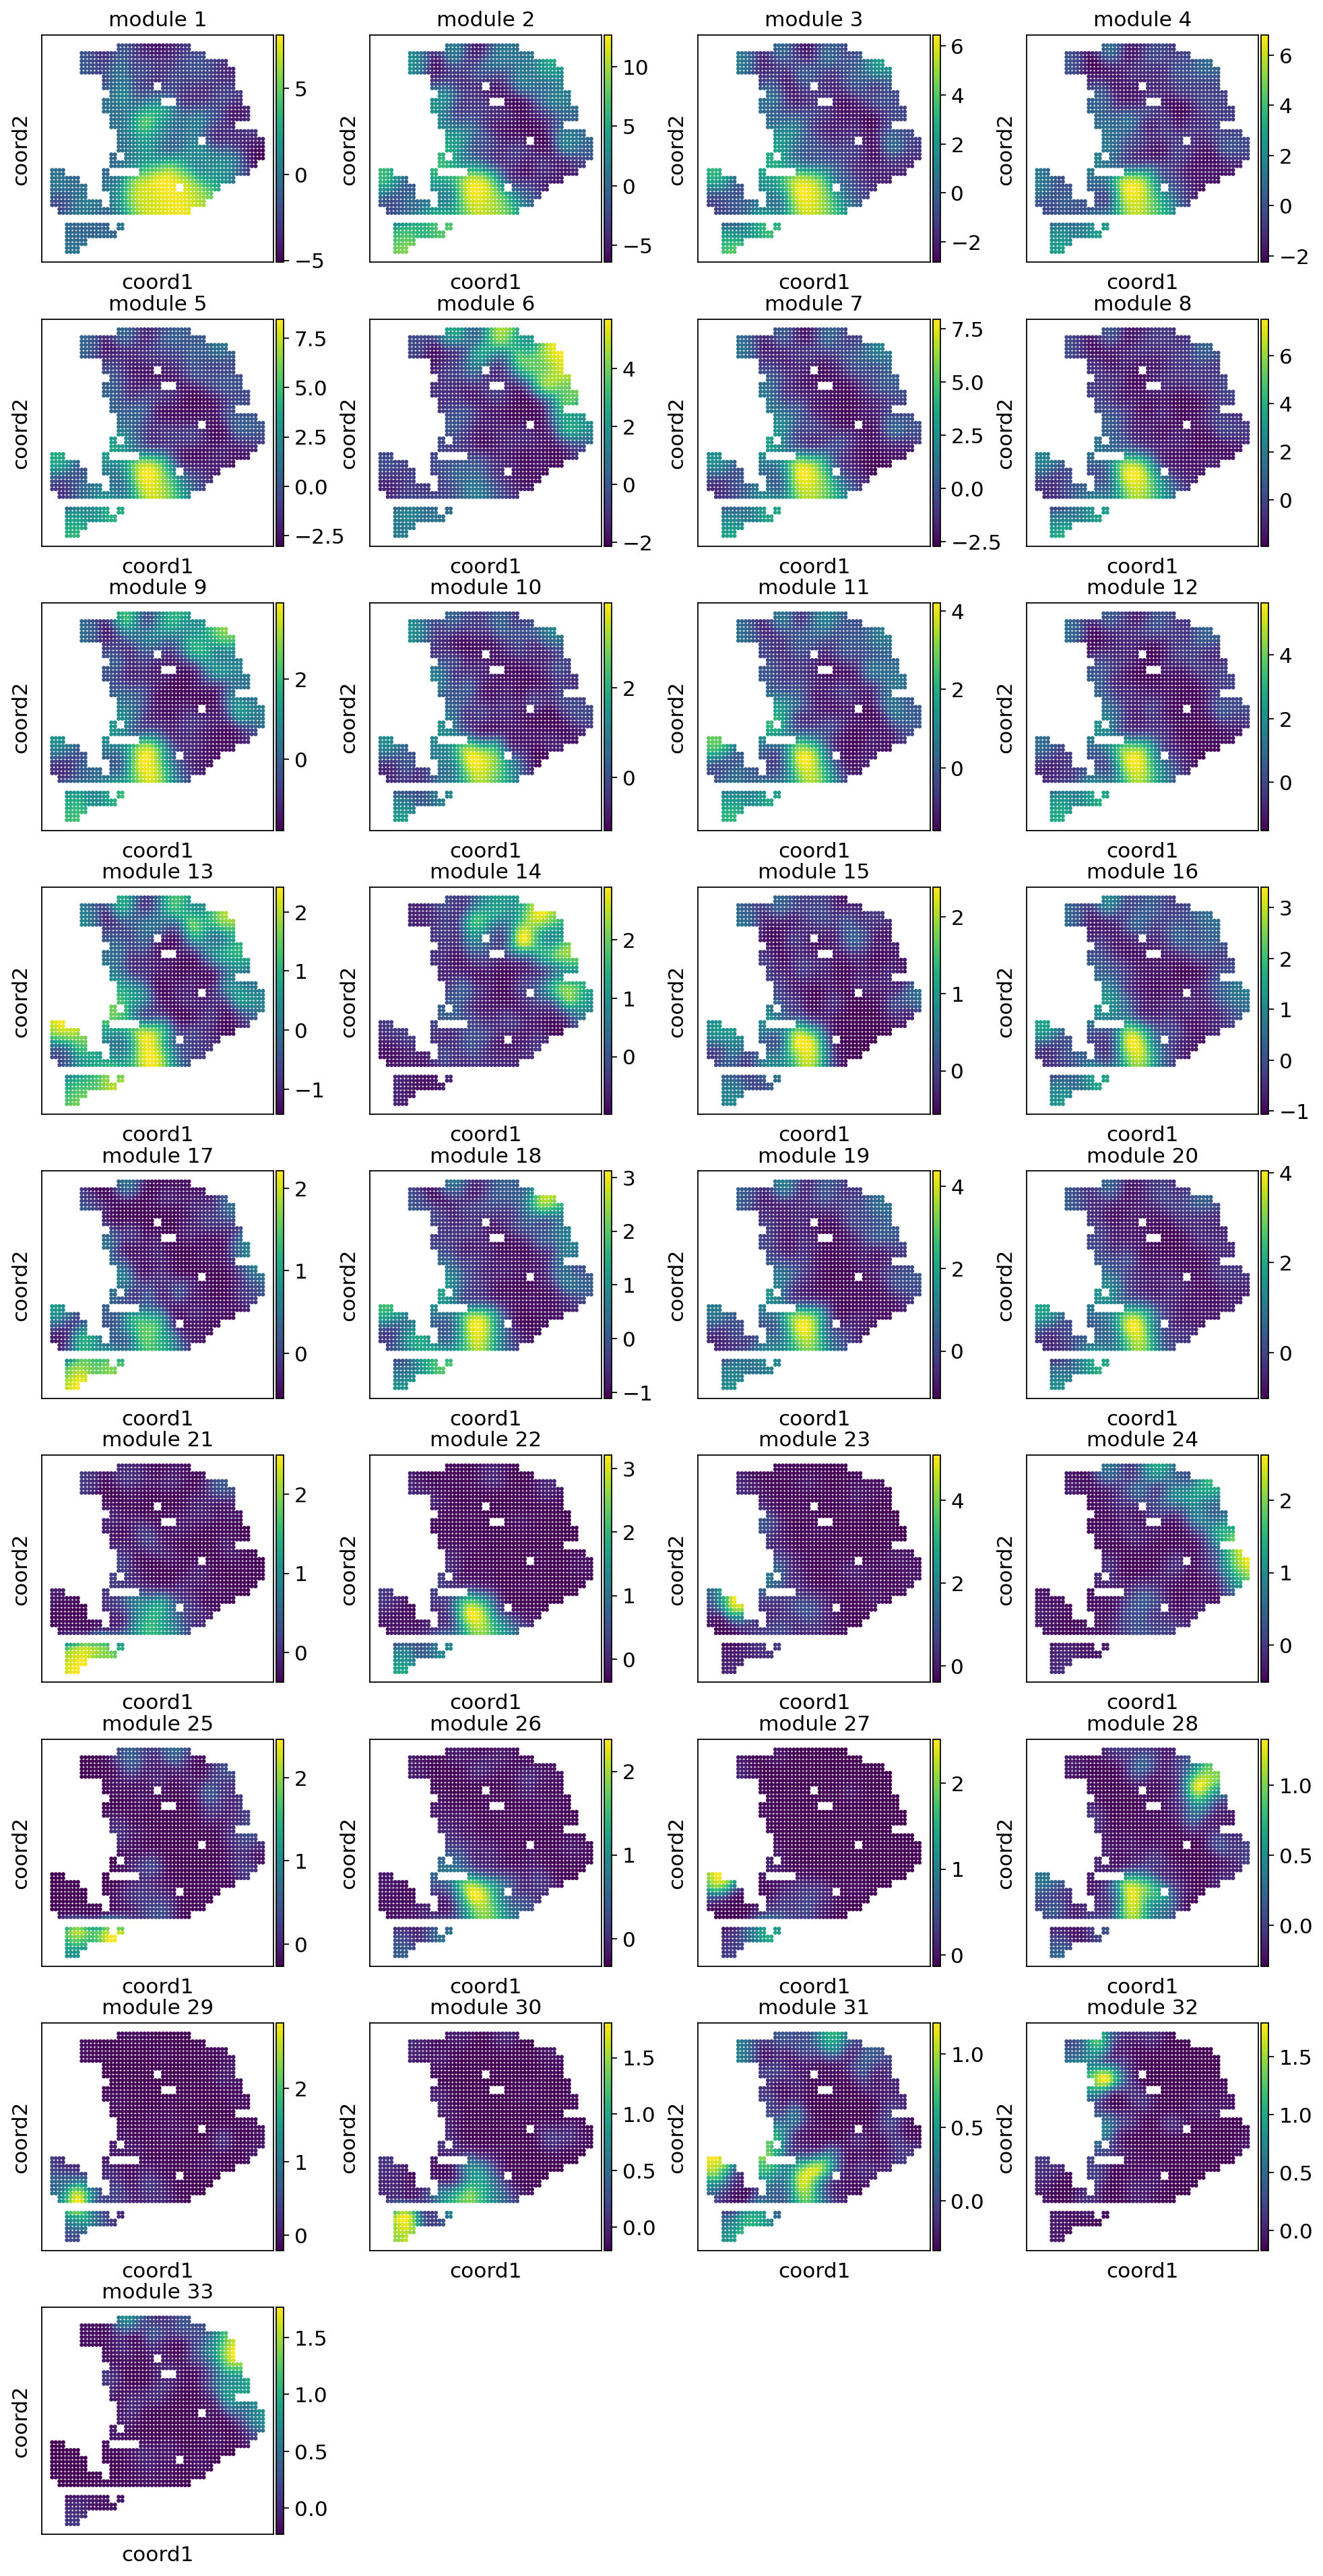

In [24]:
sc.pl.embedding(adata_stage, basis="coord", color=hs_stage.module_scores.columns, s=30, show=False)

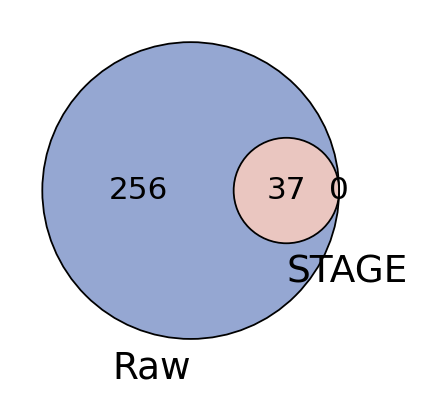

In [25]:
g=venn2(subsets = [set(hs.modules.index[hs.modules==1]), set(hs_stage.modules.index[hs_stage.modules==1])],
        set_labels = ('Raw', 'STAGE'),set_colors=("#4f6db4", "#ec7722"),alpha=0.6,normalize_to=1.0)
g=venn2_circles(subsets = [set(hs.modules.index[hs.modules==1]), set(hs_stage.modules.index[hs_stage.modules==1])], 
                linewidth=0.8, color="black") 

In [26]:
hs_stage.modules.index[hs_stage.modules==1]

Index(['CTRB2', 'CTRB1', 'MUC5B', 'CLPS', 'CEL', 'CPB1', 'GP2', 'CELA3A',
       'LCN2', 'AC079140.2', 'C3', 'EEF1A1', 'CELA3B', 'FTL', 'CD74',
       'MTRNR2L12', 'MT.ND1', 'CPA1', 'COL1A1', 'DMBT1', 'AL122020.1',
       'MTCO2P2', 'MTND1P23', 'ATP1A1', 'MMP1', 'AC026403.1', 'CLU', 'CPA2',
       'CTRC', 'CD81', 'AC034236.1', 'MTRNR2L8', 'AC024940.2', 'AC026254.2',
       'CRP', 'CLDN2', 'AC125807.1'],
      dtype='object')

In [27]:
# Select marker genes
show_gene=["CEL","CTRC","CTRB2","GP2"]

[<AxesSubplot:title={'center':'CEL'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'CTRC'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'CTRB2'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'GP2'}, xlabel='coord1', ylabel='coord2'>]

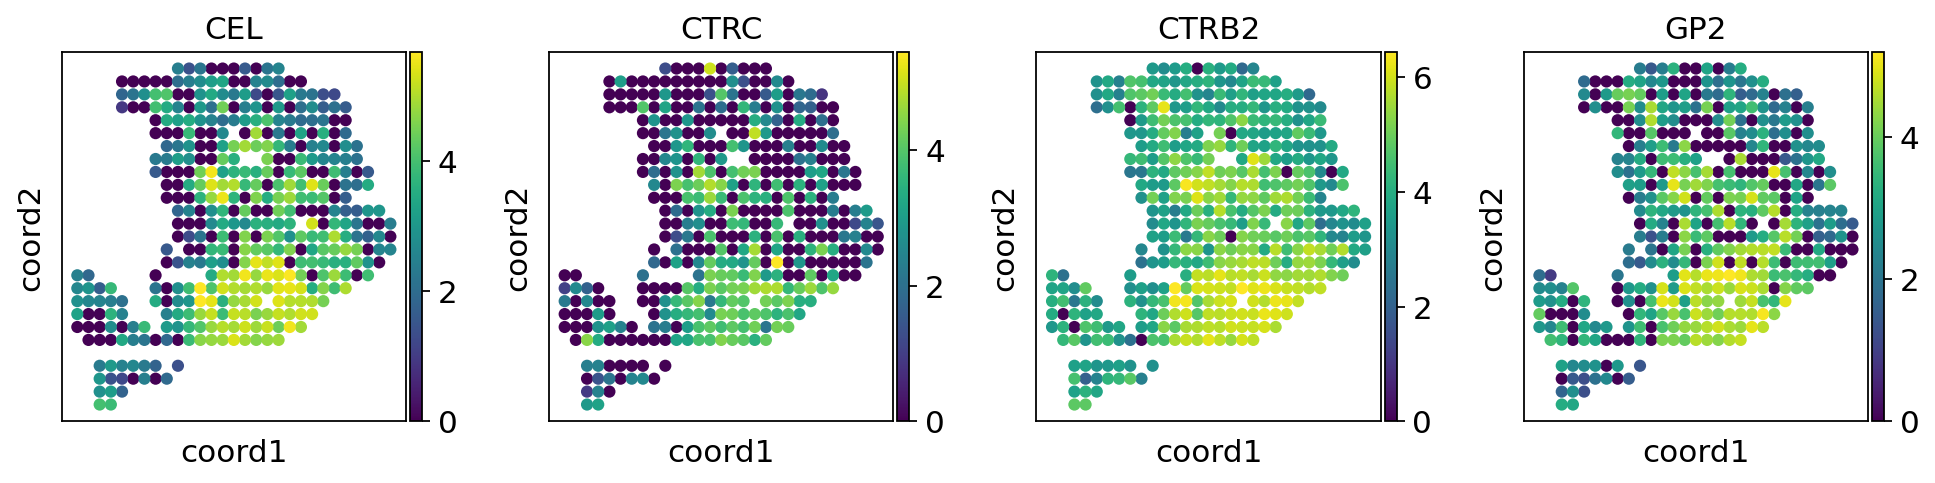

In [28]:
sc.pl.embedding(adata, basis="coord", color=show_gene, s=120, show=False)

[<AxesSubplot:title={'center':'CEL'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'CTRC'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'CTRB2'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'GP2'}, xlabel='coord1', ylabel='coord2'>]

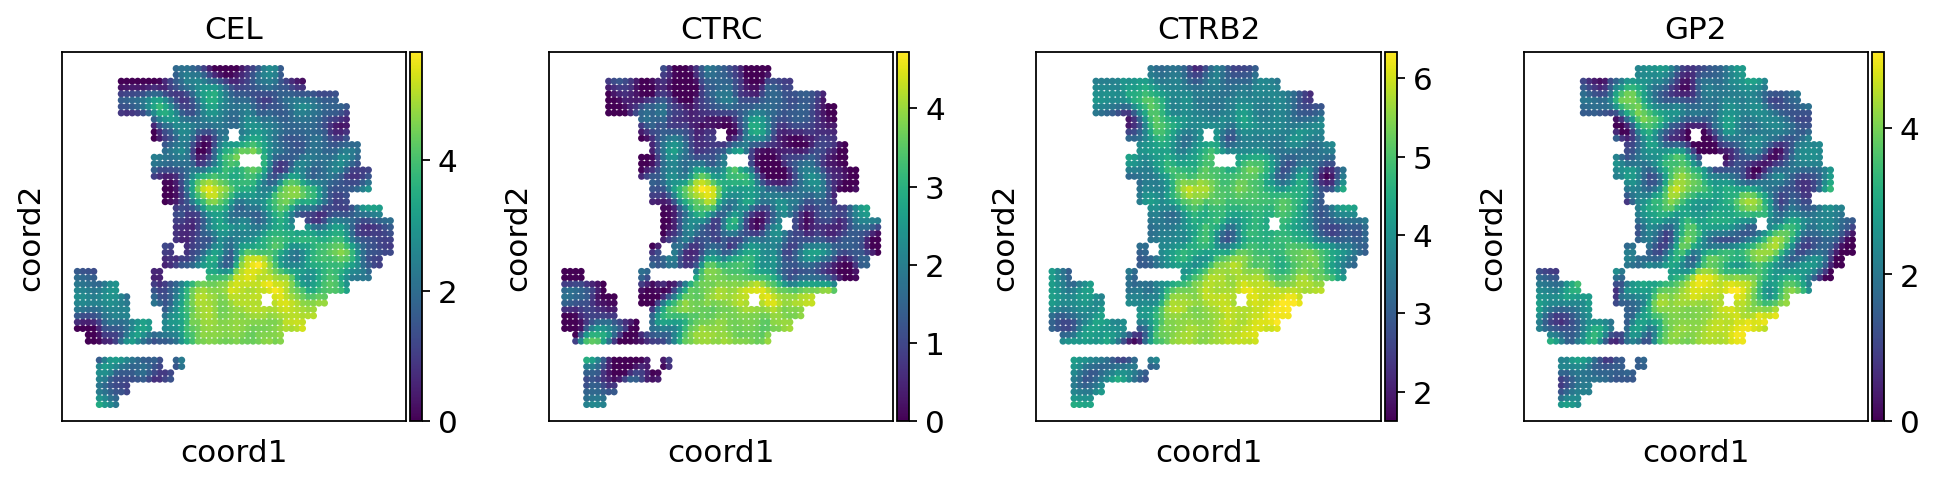

In [29]:
sc.pl.embedding(adata_stage, basis="coord", color=show_gene, s=40, show=False)